In [1]:
%reset -f

In [3]:
import os
import matplotlib.pyplot as plt
import jax
from jax import jit
import jax.numpy as jnp
import jax.random as jr
import optax
import numpy as np

***NB:*** Dans ce TP on ne travaillera qu'avec des données en batch.


Les inputs seront parfois noté `xy` (car c'est des points 2d) ou `inp`.

## Préliminaire graphique

### Plot surface

On rappelle comment tracer une surface (= une fonction $\mathbb R^2 \to  \mathbb R$) en niveau de couleur

In [4]:
x=jnp.linspace(-1,1,20)
y=jnp.linspace(-1,1,20)

X_mat,Y_mat=jnp.meshgrid(x,y,indexing="ij")
F=X_mat**2+Y_mat**2

fig,ax=plt.subplots(1,1)
ax.pcolormesh(X_mat,Y_mat,F,shading="gouraud");

### pour des fonctions mangeant des dataframe

In [5]:
x=jnp.linspace(-1,1,50)
y=jnp.linspace(-1,1,50)

X_mat,Y_mat=jnp.meshgrid(x,y,indexing="ij")
xy=jnp.stack([X_mat.flatten(),Y_mat.flatten()],axis=1)


def U_of_xy(xy): #f[b,2]->f[b,1]
    return (xy[:,0:1]**2)


fig,ax=plt.subplots(1,1)

U_at_xy=U_of_xy(xy)
U_at_xy_mat=U_at_xy.reshape(X_mat.shape)


ax.pcolormesh(X_mat,Y_mat,U_at_xy_mat,shading="gouraud");

Dans ce TP, on utilisera plutôt `contourf`

In [6]:
fig,ax=plt.subplots(1,1)
ax.contourf(X_mat,Y_mat,U_at_xy_mat,levels=50);

### Tracer des data-points

In [8]:
fig,ax=plt.subplots(1,1)
data_position_x=jnp.linspace(0,10,10)
data_position_y=data_position_x
data_value=data_position_x**2

mapa=ax.scatter(data_position_x,data_position_x,c=data_value,s=data_value,cmap="jet",marker="o",edgecolor="k");
plt.colorbar(mapa,ax=ax);


***A vous:*** Que signifie les arguments `c` et `s` dans `ax.scatter`


Dans la commande:


    plt.colorbar(mapa,ax=ax);

il faut préciser
* l'association des couleurs (les fonctions ax.plot renvoie des objets `mapable` pour cela)
*  sur quel axe on accroche la colorbar.

### Notre plotter pour la suite

La fonction ci-dessous permet de tracer le graph d'une fonction mathématique de $\mathbb R^2$ dans $\mathbb R$, en niveau de couleur, et de lui supperposer des data-points.






In [9]:
def plot_fn_and_data(U_of_xy,data_xy,data_value,x_range=[-2,2],y_range=[-2,2],n_point=50,levels=50):
    """
    U_of_xy : f[b,2]->f[b,1]

    data_xy : f[b',2]
    data_value: f[b',1]
    """
    xy_bidon=jnp.ones([1,2])
    U_at_xy_bidon=U_of_xy(xy_bidon)
    assert U_at_xy_bidon.shape==(1,1)


    b_=data_xy.shape[0]
    assert data_xy.shape[1]==2
    assert data_value.shape==(b_,1)


    x=jnp.linspace(*x_range,n_point)
    y=jnp.linspace(*y_range,n_point)

    X_mat,Y_mat=jnp.meshgrid(x,y,indexing="ij")
    xy=jnp.stack([X_mat.flatten(),Y_mat.flatten()],axis=1)


    U_at_xy=U_of_xy(xy)
    U_at_xy_mat=U_at_xy.reshape(X_mat.shape)


    #une échelle de couleur qui englobe toutes les données
    vmin_U,vmax_U=jnp.quantile(U_at_xy_mat,jnp.array([0.,1]))
    vmin_data,vmax_data=jnp.quantile(data_value,jnp.array([0.,1]))

    vmin=min(vmin_U,vmin_data)
    vmax=min(vmax_U,vmax_data)


    fig,ax=plt.subplots(1,1)
    #ax.pcolormesh(X_mat,Y_mat,U_at_xy_mat,shading="gouraud",vmin=vmin,vmax=vmax,cmap="jet")
    ax.contourf(X_mat,Y_mat,U_at_xy_mat,vmin=vmin,vmax=vmax,cmap="jet",levels=levels)
    mapa=ax.scatter(data_xy[:,0],data_xy[:,1],c=data_value[:,0],cmap="jet",marker="o",edgecolor="k",vmin=vmin,vmax=vmax)

    fig.colorbar(mapa)

***A vous:*** En lisant le code:  comment a-t-on fait pour que l'échelle des couleurs de la fonction et celle des data soient cohérente.


Le but d'un ajustement de fonction c'est de se donner d'abords les points, puis de trouver la fonction qui passe par ces points. Voici par exemple un ajustement parfait:

In [11]:
rkey=jr.key(0)
data_xy=jr.uniform(rkey,shape=[300,2],minval=-2,maxval=2)

U_of_xy=lambda xy: -xy[:,0:1]**2


data_value=U_of_xy(data_xy)


data_value.shape

In [12]:
plot_fn_and_data(U_of_xy,data_xy,data_value)

***A vous:*** Ajoutez un peu de bruit sur les points, pour que leurs couleurs différent légèrement du fond.

## Regression

### data linéaires

In [13]:
def generate_linear_data(rkey):
    """génération des données:
       Y=  X @ a + b + bruit
        """
    rk1,rk2=jr.split(rkey)
    n_data=500
    inp = jr.uniform(rk1,[n_data,2],minval=-2,maxval=2)
    a = jnp.array([1.,4])[:,None]
    b = 1.
    out = inp @ a + b + jr.normal(rk2,[n_data,1])

    return inp,out


inp_train,out_train=generate_linear_data(jr.key(0))
inp_train.shape,out_train.shape

In [14]:
fig,ax=plt.subplots()
colors=ax.scatter(inp_train[:,0],inp_train[:,1],c=out_train[:,0],cmap="jet");
fig.colorbar(colors);

In [15]:
def linear_model_fnm():

    @jax.jit
    def model_init(rkey):
        kernel=jr.normal(rkey,[2,1])/jnp.sqrt(2)
        bias=jnp.zeros([1])
        return {"kernel":kernel,"bias":bias}

    @jax.jit
    def model_apply(Θ,inp):
        return inp@Θ["kernel"]+Θ["bias"]

    return model_init,model_apply



model_init,model_apply=linear_model_fnm()
Θ=model_init(jr.key(0))
#testons
model_apply(Θ,inp_train).shape

In [16]:
def train_step_fnm(model_apply,optimizer):

    def loss_fn(Θ,inp, out_true):
        out_pred = model_apply(Θ, inp)
        return jnp.mean((out_pred - out_true)**2)

    @jax.jit
    def train_step(Θ, opt_state, inp, out_true):
        loss_value, grads = jax.value_and_grad(loss_fn)(Θ,inp, out_true)
        updates, new_opt_state = optimizer.update(grads, opt_state, Θ)
        new_Θ = optax.apply_updates(Θ, updates)
        return new_Θ, new_opt_state, loss_value

    return train_step

In [17]:
learning_rate = 0.1
optimizer = optax.adam(learning_rate)

train_step=train_step_fnm(model_apply,optimizer)

opt_state = optimizer.init(Θ)

batch_size = 32
rkey=jr.key(0)
losses=[]

for step in range(200):
    Θ, opt_state, loss = train_step(Θ, opt_state, inp_train, out_train)
    losses.append(loss)
    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss}")

In [18]:
fig,ax=plt.subplots()
ax.plot(losses)
ax.set_yscale("log");

In [19]:
U_of_xy=lambda xy:model_apply(Θ,xy)

In [20]:
plot_fn_and_data(U_of_xy,inp_train,out_train)

Et sur des données tests:

In [21]:
inp_test,out_test=generate_linear_data(jr.key(42))
plot_fn_and_data(U_of_xy,inp_test,out_test)

### Non linéaire

In [22]:
def generate_non_linear_data(rkey):
    rk1,rk2=jr.split(rkey)
    n_data=500
    inp = jr.uniform(rk1,[n_data,2],minval=-2,maxval=2)
    out = jnp.sin(2*inp[:,0]*inp[:,1]) + jr.normal(rk2,[n_data])*0.1
    return inp,out[:,None]


inp_train,out_train=generate_non_linear_data(jr.key(0))
inp_train.shape,out_train.shape

In [23]:
fig,ax=plt.subplots()
colors=ax.scatter(inp_train[:,0],inp_train[:,1],c=out_train[:,0],s=3,cmap="jet");
fig.colorbar(colors);

In [24]:
def model_fnm(layer_widths,activation_fn=jax.nn.relu,final_activation_fn=None):

    def model_init(rkey):
        params = []
        for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
            rk,rkey=jr.split(rkey)
            params.append(
                {"weight":jr.normal(rk,shape=(n_in, n_out))*jnp.sqrt(2/n_in),
                "bias":jnp.zeros([n_out])})
        return params


    def model_apply(params, inp):
        *hidden, last = params
        for layer in hidden:
            inp = activation_fn(inp @ layer['weight'] + layer['bias'])

        out = inp @ last['weight'] + last['bias']
        if final_activation_fn is None:
            return out
        else:
            return final_activation_fn(out)


    return model_init,model_apply

In [25]:
model_init,model_apply=model_fnm([2,32,32,32,1])
Θ=model_init(jr.key(0))
model_apply(Θ,inp_train).shape

In [26]:
learning_rate = 0.01
optimizer = optax.adam(learning_rate)

In [27]:
train_step=train_step_fnm(model_apply,optimizer)

In [28]:
opt_state = optimizer.init(Θ)

batch_size = 32
rkey=jr.key(0)
losses=[]

for step in range(2000):
    Θ, opt_state, loss = train_step(Θ, opt_state, inp_train, out_train)
    losses.append(loss)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")

In [29]:
fig,ax=plt.subplots()
ax.plot(losses)
ax.set_yscale("log");

In [30]:
U_of_xy=lambda inp:model_apply(Θ,inp)

In [31]:
U_of_xy(inp_train).shape

In [32]:
plot_fn_and_data(U_of_xy,inp_train,out_train)

⇑ voyez-vous quelques traces de sur-apprentissage ?

Et sur des données tests:

In [33]:
inp_test,out_test=generate_non_linear_data(jr.key(42))
plot_fn_and_data(U_of_xy,inp_test,out_test)

##  Classification binaire

### Data

In [38]:
"the moons dataset using Scikit-Learn's"
from sklearn.datasets import make_moons

In [39]:
inp_train,out_train=make_moons(500, noise=0.1)
inp_test,out_test=make_moons(3_000, noise=0.1)
out_test=out_test[:,None]
out_train=out_train[:,None]
inp_train.shape,out_train.shape

In [40]:
out_train[:10]

In [41]:
fig,ax=plt.subplots()
ax.scatter(inp_test[:,0],inp_test[:,1],c=out_test[:,0],cmap="jet",marker=".",label="test",alpha=0.3)
ax.scatter(inp_train[:,0],inp_train[:,1],c=out_train[:,0],cmap="jet",marker="+",label="train");
ax.legend();

Notre travail: déterminer 2 zones du plan où l'on a le plus de chance d'observer un point bleu/rouge.

Ces zones doivent être construites à partir du jeu de données `train`, et on calculera notre accuracy à partir du jeu de données `val`

### Modèle logistique: la théorie

#### Le modèle



Dans le cas binaire, on peut se contenter d'un modèle qui prend en entrée les points du plan  et renvoie un scalaire dans $[0,1]$ qui est la probabilité d'observer la classe rouge (=class 1) en ce point.


supposons que les points sont rangés dans une matrice `X` de shape `nb_point,2`.

La manière la plus simple de construire un tel model est:
$$
\hat p = \sigma(X \cdot w +b)
$$
ou $\sigma$ est la fonction sigmoide
$$
\sigma(x) = \color{red}{\square \square \square}
$$
C'est le modèle logistique. On peut aussi mettre la sigmoide dans la loss, dans ce cas le modèle renvoie simplement un logits:
$$
\hat \ell = \color{red}{\square \square \square}
$$

#### La loss



La loss qu'il faut utiliser c'est la binary cross entropy:

$$
loss(p,\hat p) = - \frac 1 m \sum\limits_{i=0}^{m-1}\left[ p_i \log\left(\hat{p}_i\right) +\color{red}{\square \square \square} \right]
$$


ou bien sa version "from logits":
$$
loss(p,\hat \ell) = - \frac 1 m \sum\limits_{i=0}^{m-1}\left[ p_i \log\left( \sigma(\hat{\ell})_i\right) + \color{red}{\square \square \square} \right]
$$
où $\sigma$ est la fonction sigmoide


Attention: pour éviter $\log(0)$ on peut ajouter un $\epsilon$ dans les log, ou bien clipper $\hat p$ dans un intervalle $[\epsilon, 1-\epsilon]$. Ce second choix est utilisé par les lib récentes.

### La pratique

In [42]:
#Pas besoin de vmap, on va utiliser @ qui est universel
def logistic_model_fnm():

    @jax.jit
    def model_init(rkey):
        kernel=jr.normal(rkey,[2,1])/jnp.sqrt(2)
        bias=jnp.zeros([1])
        return {"kernel":kernel,"bias":bias}

    @jax.jit
    def model_apply(Θ,inp):
        return jax.nn.sigmoid(inp@Θ["kernel"]+Θ["bias"])

    return model_init,model_apply



model_init,model_apply=logistic_model_fnm()
Θ=model_init(jr.key(0))
#testons
out_pred=model_apply(Θ,inp_train)
out_pred.shape

In [43]:
out_pred[:10]

⇑ c'est bien des probabilités

In [44]:
def train_step_fnm(model_apply,optimizer,mse_loss):

    def loss_fn(Θ,inp, out_true):
        out_pred = model_apply(Θ, inp)
        #TODO: ce n'est pas la loss canonique pour une classification binaire !!!
        if mse_loss:
            return jnp.mean((out_pred - out_true)**2)
        else:
            out_pred = jnp.clip(out_pred, 1e-7, 1 - 1e-7)
            return ...


    @jax.jit
    def train_step(Θ, opt_state, inpV, outV_true):
        loss_value, grads = jax.value_and_grad(loss_fn)(Θ,inpV, outV_true)
        updates, new_opt_state = optimizer.update(grads, opt_state, Θ)
        new_Θ = optax.apply_updates(Θ, updates)
        return new_Θ, new_opt_state, loss_value

    return train_step

In [45]:
learning_rate = 0.01
optimizer = optax.adam(learning_rate)
train_step=train_step_fnm(model_apply,optimizer,mse_loss=True)


opt_state = optimizer.init(Θ)

batch_size = 32
rkey=jr.key(0)
losses=[]

for step in range(5000):
    Θ, opt_state, loss = train_step(Θ, opt_state, inp_train, out_train)
    losses.append(loss)


fig,ax=plt.subplots()
ax.plot(losses)
ax.set_yscale("log")
print(f"last loss:{losses[-1]}")

In [46]:
U_of_xy=lambda inp:model_apply(Θ,inp)

In [47]:
U_of_xy(inp_train).shape

In [48]:
plot_fn_and_data(U_of_xy,inp_train,out_train)

Et sur des données tests:

In [49]:
plot_fn_and_data(U_of_xy,inp_test,out_test)

### Précision (accuracy)

C'est le pourcentage de bien classé

In [50]:
def accuracy(U_of_xy,inp,out):
    out_pred_proba=U_of_xy(inp)
    out_pred=out_pred_proba>0.5
    good= (out_pred==out)
    return jnp.mean(good)

In [51]:
accuracy(U_of_xy,inp_train,out_train)

In [52]:
accuracy(U_of_xy,inp_test,out_test)

### A plusieurs couches

 On voit que ce n'est pas tout à fait optimal car la frontière est "anguleuse". Faites le lien en cette angulosité et la fonction d'activation choisie.

In [53]:
model_init,model_apply=model_fnm([2,32,32,32,1],final_activation_fn=jax.nn.sigmoid)
Θ=model_init(jr.key(0))
model_apply(Θ,inp_train).shape


In [54]:
train_step=train_step_fnm(model_apply,optimizer,mse_loss=True)

learning_rate = 0.01
optimizer = optax.adam(learning_rate)

opt_state = optimizer.init(Θ)

batch_size = 32
rkey=jr.key(0)
losses=[]

for step in range(500):
    Θ, opt_state, loss = train_step(Θ, opt_state, inp_train, out_train)
    losses.append(loss)


fig,ax=plt.subplots()
ax.plot(losses)
ax.set_yscale("log");

In [55]:
U_of_xy=lambda inp:model_apply(Θ,inp)
U_of_xy(inp_train).shape

In [56]:
plot_fn_and_data(U_of_xy,inp_train,out_train)

Et sur des données tests:

In [57]:
plot_fn_and_data(U_of_xy,inp_test,out_test)

In [58]:
accuracy(U_of_xy,inp_test,out_test)

***A vous:*** Implémentez l'option `mse_loss=False` dans `train_step_fnm`. Vous optiendrez des accuracy similaire.

Cependant, pour des problème plus complexe, il est fortement recommandé d'utiliser la cross-entropy-binaire et pas une mse. Pourquoi:


* Pénalisation inadaptée : La MSE peut pénaliser excessivement les prédictions correctes mais non parfaites. Par exemple, si une classe réelle est 1 et que le modèle prédit 0.9 (ce qui est proche), la MSE appliquera une pénalité quadratique (0.01), tandis que l'entropie croisée donnera une perte plus faible, mieux adaptée à l'interprétation probabiliste.
À l'inverse, la MSE peut sous-pénaliser des prédictions très confiantes mais erronées (par exemple, prédire 0.9 pour une classe réelle 0).


* Problèmes de convergence : La MSE peut entraîner des gradients qui ne sont pas bien adaptés pour optimiser des modèles de classification, surtout avec des fonctions d'activation comme la sigmoïde. Cela peut ralentir la convergence ou conduire à des minima sous-optimaux.
La binary cross-entropy, combinée à une activation sigmoïde, produit des gradients plus stables et adaptés à la classification binaire.

### Expériences

En changeant un peu le modèle, sauriez vous obtenir cette frontière de décision ?

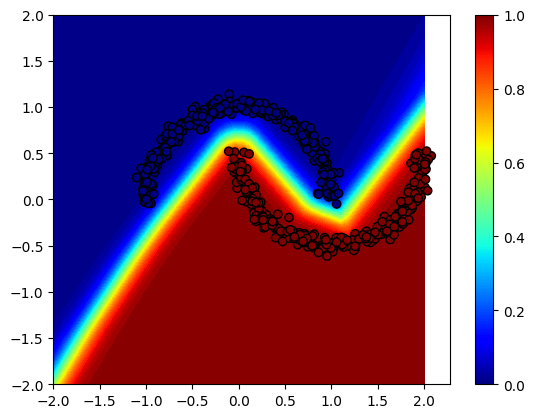

## Classification multi-classes


### Data

In [59]:
n_class=3

In [60]:
def generate_spiral_dataset(n_point_per_class, n_class, rkey, noise=0.04):

    X = []
    y = []

    for class_idx in range(n_class):
        # Générer des angles pour la spirale
        theta = jnp.linspace(0, 2 * jnp.pi, n_point_per_class)
        # Rayon augmente linéairement avec l'angle
        radius = jnp.linspace(0.0, 1.0, n_point_per_class)
        # Décalage angulaire pour chaque classe
        angle_offset = 2 * jnp.pi * class_idx / n_class

        # Coordonnées des points pour cette classe
        x = radius * jnp.cos(theta + angle_offset)
        y_coords = radius * jnp.sin(theta + angle_offset)

        # Ajout de bruit
        key, subkey = jr.split(rkey)
        noise_x = jr.normal(subkey, (n_point_per_class,)) * noise
        key, subkey = jr.split(key)
        noise_y = jr.normal(subkey, (n_point_per_class,)) * noise

        x += noise_x
        y_coords += noise_y

        # Empiler les coordonnées
        points = jnp.stack([x, y_coords], axis=1)
        X.append(points)
        y.append(jnp.full(n_point_per_class, class_idx))

    # Concaténer les données
    X = jnp.concatenate(X, axis=0)
    y = jnp.concatenate(y, axis=0)

    return X, y

In [61]:
inp_train, out_train = generate_spiral_dataset(n_point_per_class=100, n_class=n_class,rkey=jr.key(0))
inp_train.shape,out_train.shape

In [62]:
out_train[:10]

In [63]:
out_train[-10:]

⇑ Attention, les données sont ordonnées. Mais ce n'est pas grave pour la suite.

Comme l'output est une suite d'indice, on ne le transforme pas en dataframe (on n'ajoute pas une dimension artificielle).

In [64]:
fig,ax=plt.subplots()
plt.scatter(inp_train[:,0],inp_train[:,1],c=out_train);

In [65]:
model_init,model_apply=model_fnm([2,32,32,32,n_class])
Θ=model_init(jr.key(0))
out_pred_bidon=model_apply(Θ,inp_train)
out_pred_bidon.shape

In [66]:
out_pred_bidon[:5]

⇑ la somme des lignes ne fait pas 1: notre modèle ressort des logits, il faudra faire attention de mettre le soft-max dans la loss!

In [104]:
def loss_fn_hand_made(logits,out_true):

    # Normaliser les logits en probabilités
    probas = jax.nn.softmax(logits, axis=1)

    # Sélectionner les probabilités prédites correspondant aux étiquettes vraies
    batch_size = out_true.shape[0]
    indices = jnp.arange(batch_size)
    return  - jnp.log(probas[indices, out_true])

In [105]:
logits=jnp.array([[3.,6.],[0.5,2]])
out_true=jnp.array([0,1])

In [106]:
loss_fn_hand_made(logits,out_true)

In [107]:
optax.softmax_cross_entropy_with_integer_labels(logits,out_true)

In [111]:
def train_step_fnm(model_apply,optimizer):


    def compute_loss(Θ,inp,labels):
        logits=model_apply(Θ,inp)
        return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits,labels))


    @jax.jit
    def train_step(Θ, opt_state, inp, labels):
        loss_value, grads = jax.value_and_grad(compute_loss)(Θ,inp, labels)
        updates, new_opt_state = optimizer.update(grads, opt_state, Θ)
        new_Θ = optax.apply_updates(Θ, updates)
        return new_Θ, new_opt_state, loss_value

    return train_step

In [112]:
train_step=train_step_fnm(model_apply,optimizer)

learning_rate = 0.01
optimizer = optax.adam(learning_rate)

opt_state = optimizer.init(Θ)

batch_size = 32
rkey=jr.key(0)
losses=[]

for step in range(500):
    Θ, opt_state, loss = train_step(Θ, opt_state, inp_train, out_train)
    losses.append(loss)


fig,ax=plt.subplots()
ax.plot(losses)
ax.set_yscale("log");

In [113]:
model_apply(Θ,inp_train).shape

In [114]:
U_of_xy=lambda inp:jnp.argmax(model_apply(Θ,inp),axis=1,keepdims=True)
U_of_xy(inp_train).shape

In [115]:
plot_fn_and_data(U_of_xy,inp_train,out_train[:,None])

### Expérience

Changez la fonction d'activation de `relu` a `elu`. Pour moi cela a donné ceci:

Notez que cela donne la même accuracy, mais le modèle a été plus "inventif".

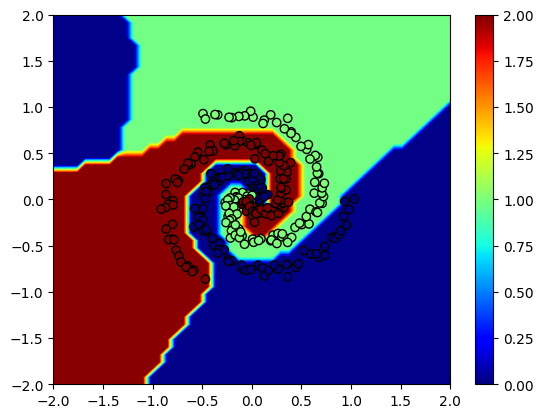